In [57]:
"""Run experiments as reported in the paper."""
import os
import sys
from itertools import product

sys.path.append(os.path.realpath("."))
root_path = os.path.join(os.path.expanduser('~'), 'sequential-auction-on-gpu')
if root_path not in sys.path:
    sys.path.append(root_path)

from time import perf_counter as timer
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from cycler import cycler
colors = [(0/255.,191/255.,196/255.), (248/255.,118/255.,109/255.),
          (150/255.,120/255.,170/255.), (200/255.,185/255.,130/255.)]

import src.utils.env_utils as env_ut
import src.utils.io_utils as io_ut
from src.learners.multi_agent_learner import MultiAgentCoordinator

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

In [51]:
device = 2
runs = 1
policy_sharing = True

num_rounds_to_play_options = [1, 2]
num_simulations_options = [100, 10_000, 100_000, 1_000_000]
action_discretization_options = [4, 8, 16, 32]

In [52]:
utility_losses = np.zeros((
    runs,
    len(num_rounds_to_play_options),
    len(num_simulations_options),
    len(action_discretization_options)
))
elapsed_times = np.zeros_like(utility_losses)

options = enumerated_product(
    num_rounds_to_play_options,
    num_simulations_options,
    action_discretization_options,
)
for idx, option in options:
    num_rounds_to_play, num_simulations, action_discretization = option

    for i in range(runs):
        config = io_ut.get_config([
            f"seed={i}",
            f"device={device}",
            f"policy_sharing={policy_sharing}",
            f"verify_br=true",
            f"verifier.num_simulations={num_simulations}",
            f"verifier.action_discretization={action_discretization}",
            f"rl_envs.num_rounds_to_play={num_rounds_to_play}",
            f"rl_envs.num_agents={num_rounds_to_play + 1}",
            f"delete_logs_after_training=true",
        ])
        env = env_ut.get_env(config)
        ma_learner = MultiAgentCoordinator(config, env)

        tic = timer()
        utility_losses_for_all_agents = ma_learner.verify_in_BNE().values()
        elapsed_time = timer() - tic

        utility_losses[(i,) + idx] = np.mean(list(utility_losses_for_all_agents))
        elapsed_times[(i,) + idx] = elapsed_time

        # Wrap up
        io_ut.wrap_up_experiment_logging(config)

In [59]:
def plot(metric, time):
    markers = ['o', '^', 's', 'p', '.', '+'] * 3
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    for ax, y in zip(axs, [metric, time]):
        for j, num_simulations in enumerate(action_discretization_options):
            mean, std = y[:, :, j].mean(axis=0), y[:, :, j].std(axis=0)
            ax.plot(num_simulations_options, mean,
                    label=f'{num_simulations}',
                    ms=7, color=colors[j], marker=markers[j])
            ax.fill_between(num_simulations_options, mean-std, mean+std, alpha=.3,
                            color=colors[j])
        ax.set_xlabel('number of simulations')
        ax.grid(linestyle='--'); ax.set_xscale('log', base=2);
    axs[1].set_yscale('log', base=10)
    axs[0].legend(title="discretization")
    return axs

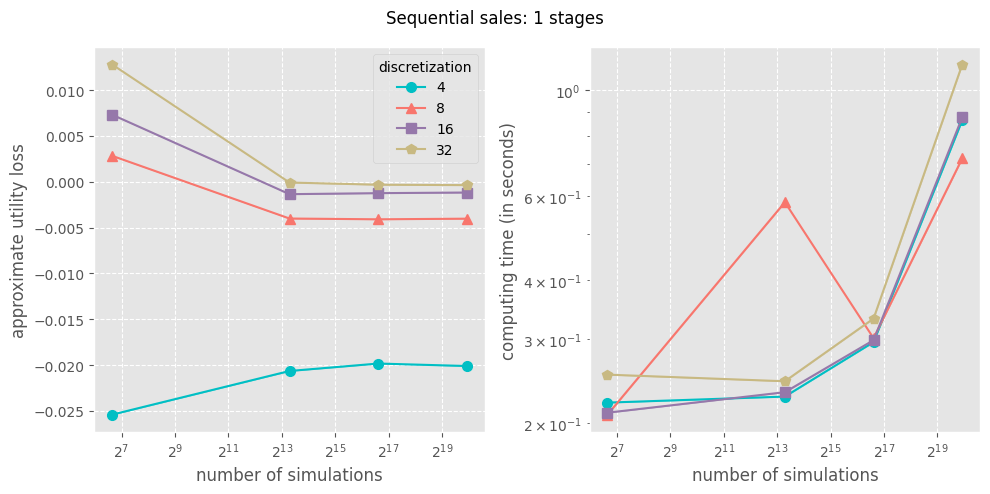

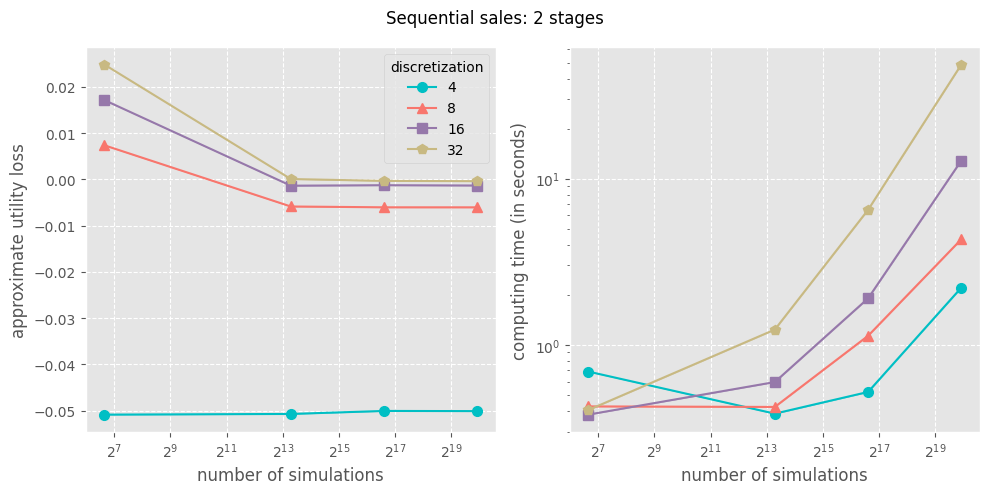

In [64]:
for j, num_rounds_to_play in enumerate(num_rounds_to_play_options):
    axs = plot(utility_losses[:, j, :, :], elapsed_times[:, j, :, :])
    plt.suptitle(f"Sequential sales: {num_rounds_to_play} stages")
    axs[0].set_ylabel('approximate utility loss')
    axs[1].set_ylabel('computing time (in seconds)')
    plt.tight_layout(); plt.savefig(f'../logs/utility_loss_analysis_{num_rounds_to_play}_stages.pdf')
    plt.show()